<a href="https://colab.research.google.com/github/xy2119/SO3_Invariant_ProteinMPNN/blob/main/notebooks/SO3_invariant_representations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rotation Invariant Representaion for ProteinMPNN | 10th March
**List of content**

1. Relative Position Mapping
  *  Test Rotation Invariance in 3D
  *  Encode Chiral Centre?

2. Real Spherical Harmonics Expansion
  *  Test Rotation Invariance in 2D
  *  Encode Chiral Centre?
  

## Conclusion:
Both two representations:
*   can encode differently for different matrix  
*   can encode the same for rotated matrices

*   can not differetiate opposite direction spirals



###### Notes:
Input matrix shape : `[B,N,C,3]`

  * `B` number of samples in the batch (batch size)

  * `N` number of residues

  * `C` number of residue coordinates

  * `3` 3D coordinate in Cartesian space
 



# 1. Relative Position Mapping 

> Construct coordinate system using (vi,vj,vk) 

> Project v_ij onto the constructed coordinate system





**Conclusion**:

*   Encode differently for different matrix  
*   Encode the same for rotated matrices
*   Encode the same for opposite direction spirals  

<img src="https://drive.google.com/file/d/1TuJuGbaurpc7JbbgSvtMx0PGOr2uZI8H/view?usp=sharing" width="600">

In [ ]:
import torch
import math

def get_relative_position_mapping(coordinates,k=3):
    #[B,N,C,3]
    print('Input shape:',coordinates.shape)
    X = coordinates

    # Initialize empty tensor to store the mapping of relative positions  
    relative_positions = torch.zeros((coordinates.shape[0], coordinates.shape[1], math.comb(coordinates.shape[2], 3), 3))

    # Loop over each residue in each protein structure
    for b in range(coordinates.shape[0]):
        for n in range(coordinates.shape[1]):
            # Compute pairwise distances between atoms
            dists = torch.norm(coordinates[b, n, None, :] - coordinates[b, n, :, None], dim=-1)
            #print('dists',b,n,'\n',dists)

            # Get the indices of the k closest neighbors for each atom
            _, indices = torch.topk(dists, k=k, dim=-1, largest=False, sorted=True)
            #print('indices\n',indices)
            
            count=0
            unique_combinations = []
            
            for i in indices[ :,0].flatten():
                vi = X[b,n,i,:]
                for j in indices[1:].flatten():
                    if j != i:
                        vj = X[b,n,j,:]

                        # Construct the vector vij from vi and vj
                        v_ij = vj - vi
                        v_ij = v_ij / (torch.norm(v_ij, dim=-1, keepdim=True) + 1e-6)

                        for k in indices[1:].flatten():
                            if k != i and k != j:   
                                # Convert combination to sorted tuple and avoid duplicated coordinate system being created                    
                                indices_tuple = tuple(sorted([i, j, k]))
                                if indices_tuple not in unique_combinations: 
                                    unique_combinations.append(indices_tuple)

                                    # Construct the vector vik that is closest to the plane defined by vi and vk
                                    vk = X[b,n,k,:]
                                    v_ik = vk - vi
                                    v_ik = v_ik / (torch.norm(v_ik, dim=-1, keepdim=True) + 1e-6)
                                    
                                    # Construct the vector vjk, that is closest to the plane defined by vj and vk
                                    v_jk = vk - vj
                                    v_jk = v_jk / (torch.norm(v_jk, dim=-1, keepdim=True) + 1e-6)
                                    print('\n\n','-'*15,' Creating Coordinate Systems with triplet (vi,vj,vk)','-'*15)
                                    print('vi:',vi)
                                    print('vj:',vj)
                                    print('vk:',vk)
                                    
                                    # Construct the coordinate system
                                    z_axis = v_jk
                                    y_axis = torch.cross(v_ik, v_jk, dim=-1)
                                    x_axis = torch.cross(z_axis, y_axis, dim=-1)
                     
                                    # Project v_ij onto the coordinate system
                                    x_component = torch.sum(v_ij* x_axis, dim=-1)
                                    y_component = torch.sum(v_ij* y_axis, dim=-1)
                                    z_component = torch.sum(v_ij* z_axis, dim=-1)
                                    #print('\nv_ij projection onto x axis:',x_component)
                                    #print('v_ij projection onto y axis:',y_component)
                                    #print('v_ij projection onto z axis:',z_component)

                                    print('v_ij projection onto the coordinate system:',torch.stack([x_component, y_component, z_component], dim=-1),'\n\n')

                                    # Store the relative positions in the output tensor
                                    relative_positions[b,n,count,:] = torch.stack([x_component, y_component, z_component], dim=-1)

                                    count+=1

    print('\n','#'*20,' Relative Position Mappping all done ! ','#'*20)
    print('\nNo. of created coordinate systems:',count)
    print('Output shape:',relative_positions.shape)
    print(f'\nInvariant relative_positions: \n{relative_positions} ')
    return relative_positions # [B,N,no. of created coordinate systems,3]


coordinates=torch.Tensor([[[[1,0,1],[1,1,0],[3,2,2],[3,2,1],[30,20,30],[50,30,30]]]]) 
relative_positions=get_relative_position_mapping(coordinates)

Input shape: torch.Size([1, 1, 6, 3])


 ---------------  Creating Coordinate Systems with triplet (vi,vj,vk) ---------------
vi: tensor([1., 0., 1.])
vj: tensor([1., 1., 0.])
vk: tensor([3., 2., 1.])
v_ij projection onto the coordinate system: tensor([0.5000, 0.0000, 0.0000]) 




 ---------------  Creating Coordinate Systems with triplet (vi,vj,vk) ---------------
vi: tensor([1., 0., 1.])
vj: tensor([1., 1., 0.])
vk: tensor([3., 2., 2.])
v_ij projection onto the coordinate system: tensor([ 0.4452,  0.0000, -0.2357]) 




 ---------------  Creating Coordinate Systems with triplet (vi,vj,vk) ---------------
vi: tensor([1., 0., 1.])
vj: tensor([1., 1., 0.])
vk: tensor([30., 20., 30.])
v_ij projection onto the coordinate system: tensor([ 3.0102e-02,  2.7940e-09, -1.6965e-01]) 




 ---------------  Creating Coordinate Systems with triplet (vi,vj,vk) ---------------
vi: tensor([1., 0., 1.])
vj: tensor([1., 1., 0.])
vk: tensor([50., 30., 30.])
v_ij projection onto the coordinate system: te

In [ ]:
#@title #Test Rotation Invariance in 3D
import torch
import math

def get_relative_position_mapping(coordinates,k=3):
    #[B,N,C,3]
    print('Input shape:',coordinates.shape)
    X = coordinates

    # Initialize empty tensor to store the mapping of relative positions  
    relative_positions = torch.zeros((coordinates.shape[0], coordinates.shape[1], math.comb(coordinates.shape[2], 3), 3))

    # Loop over each residue in each protein structure
    for b in range(coordinates.shape[0]):
        for n in range(coordinates.shape[1]):
            # Compute pairwise distances between atoms
            dists = torch.norm(coordinates[b, n, None, :] - coordinates[b, n, :, None], dim=-1)
            #print('dists',b,n,'\n',dists)

            # Get the indices of the k closest neighbors for each atom
            _, indices = torch.topk(dists, k=k, dim=-1, largest=False, sorted=True)
            #print('indices\n',indices)
            
            count=0
            unique_combinations = []
            
            for i in indices[ :,0].flatten():
                vi = X[b,n,i,:]
                for j in indices[1:].flatten():
                    if j != i:
                        vj = X[b,n,j,:]

                        # Construct the vector vij from vi and vj
                        v_ij = vj - vi
                        v_ij = v_ij / (torch.norm(v_ij, dim=-1, keepdim=True) + 1e-6)

                        for k in indices[1:].flatten():
                            if k != i and k != j:   
                                # Convert combination to sorted tuple and avoid duplicated coordinate system being created                    
                                indices_tuple = tuple(sorted([i, j, k]))
                                if indices_tuple not in unique_combinations: 
                                    unique_combinations.append(indices_tuple)

                                    # Construct the vector vik that is closest to the plane defined by vi and vk
                                    vk = X[b,n,k,:]
                                    v_ik = vk - vi
                                    v_ik = v_ik / (torch.norm(v_ik, dim=-1, keepdim=True) + 1e-6)
                                    
                                    # Construct the vector vjk, that is closest to the plane defined by vj and vk
                                    v_jk = vk - vj
                                    v_jk = v_jk / (torch.norm(v_jk, dim=-1, keepdim=True) + 1e-6)
                                    #print('\n\n','-'*15,' Creating Coordinate Systems with triplet (vi,vj,vk)','-'*15)
                                    #print('vi:',vi)
                                    #print('vj:',vj)
                                    #print('vk:',vk)
                                    
                                    # Construct the coordinate system
                                    z_axis = v_jk
                                    y_axis = torch.cross(v_ik, v_jk, dim=-1)
                                    x_axis = torch.cross(z_axis, y_axis, dim=-1)

                                    # Project v_ij onto the coordinate system
                                    x_component = torch.sum(v_ij* x_axis, dim=-1)
                                    y_component = torch.sum(v_ij* y_axis, dim=-1)
                                    z_component = torch.sum(v_ij* z_axis, dim=-1)
                                    #print('\nv_ij projection onto x axis:',x_component)
                                    #print('v_ij projection onto y axis:',y_component)
                                    #print('v_ij projection onto z axis:',z_component)

                                    #print('v_ij projection onto the coordinate system:',torch.stack([x_component, y_component, z_component], dim=-1),'\n\n')

                                    # Store the relative positions in the output tensor
                                    relative_positions[b,n,count,:] = torch.stack([x_component, y_component, z_component], dim=-1)

                                    count+=1

    #print('\n','#'*20,' Relative Position Mappping all done ! ','#'*20)
    #print('\nNo. of created coordinate systems:',count)
    print('Output shape:',relative_positions.shape)
    print(f'\nInvariant relative_positions: \n{relative_positions} ')
    return relative_positions # [B,N,no. of created coordinate systems,3]


coordinates=torch.Tensor([[[[1,0,1],
                            [1,1,0],
                            [3,2,2]],
                           [[1,0,1],
                            [1,1,0],
                            [3,2,1]],
                           [[1,0,1],
                            [1,1,0],
                            [3,2,3]]]]) 

print(" Original coordinates:\n ",coordinates)
relative_positions=get_relative_position_mapping(coordinates,k=3)


theta = torch.tensor(145)  
theta_rad = torch.deg2rad(theta)  

R = torch.tensor([[torch.cos(theta_rad), -torch.sin(theta_rad), 0],
                  [torch.sin(theta_rad), torch.cos(theta_rad), 0],
                  [0, 0, 1]])
X = torch.matmul(coordinates, R)
X = X.view(coordinates.shape[0], coordinates.shape[1], 3, 3)
print('\n\n','-'*15,f" Rotating Coordinates by {theta} Degrees ",'-'*15)

print(" Rotated coordinates:\n ", X)
relative_positions_rotated=get_relative_position_mapping(X,k=3)

 Original coordinates:
  tensor([[[[1., 0., 1.],
          [1., 1., 0.],
          [3., 2., 2.]],

         [[1., 0., 1.],
          [1., 1., 0.],
          [3., 2., 1.]],

         [[1., 0., 1.],
          [1., 1., 0.],
          [3., 2., 3.]]]])
Input shape: torch.Size([1, 3, 3, 3])
Output shape: torch.Size([1, 3, 1, 3])

Invariant relative_positions: 
tensor([[[[ 4.4521e-01,  0.0000e+00, -2.3570e-01]],

         [[ 5.0000e-01,  0.0000e+00,  0.0000e+00]],

         [[ 3.4993e-01,  7.4506e-09, -3.7796e-01]]]]) 


 ---------------  Rotating Coordinates by 145 Degrees  ---------------
 Rotated coordinates:
  tensor([[[[-0.8192, -0.5736,  1.0000],
          [-0.2456, -1.3927,  0.0000],
          [-1.3103, -3.3590,  2.0000]],

         [[-0.8192, -0.5736,  1.0000],
          [-0.2456, -1.3927,  0.0000],
          [-1.3103, -3.3590,  1.0000]],

         [[-0.8192, -0.5736,  1.0000],
          [-0.2456, -1.3927,  0.0000],
          [-1.3103, -3.3590,  3.0000]]]])
Input shape: torch.Size([1,

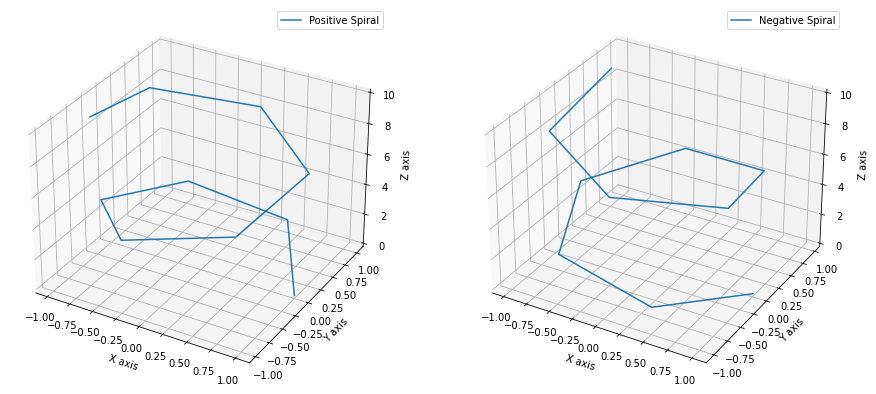

In [ ]:
#@title #Encode Chiral Centre?
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Generate the points along a logarithmic spiral
num_points = 10
t = np.linspace(0, 10, num_points)
x = np.cos(t)
y = np.sin(t)
z = t

# Plot the spirals in opposite directions
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(121, projection='3d')
ax.plot(x, y, z, label='Positive Spiral')
ax.legend()

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


x_opposite = np.cos(t) 
y_opposite = np.sin(-t) 
z_opposite = t

ax1 = fig.add_subplot(122, projection='3d')
ax1.plot(x_opposite, y_opposite, z_opposite, label='Negative Spiral')
ax1.legend()
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis')

plt.show()

In [ ]:
# stack
coordinates = np.column_stack((x, y, z))
coordinates_opposite= np.column_stack((x_opposite, y_opposite, z_opposite))

# reshape
coordinates=coordinates.reshape(1,coordinates.shape[0],-1)
coordinates_opposite=coordinates.reshape(1,coordinates_opposite.shape[0],-1)

In [ ]:
coordinates = torch.from_numpy(coordinates).unsqueeze(0)
relative_pos = get_relative_position_mapping(coordinates,k=3)

Input shape: torch.Size([1, 1, 10, 3])
Output shape: torch.Size([1, 1, 120, 3])

Invariant relative_positions: 
tensor([[[[ 2.4572e-01, -2.7756e-17,  7.3628e-01],
          [ 2.8661e-01,  1.3878e-17,  5.2312e-01],
          [ 2.7038e-01,  5.5511e-17,  4.0859e-01],
          [ 2.1413e-01,  1.7347e-17,  4.6604e-01],
          [ 1.3736e-01,  8.6736e-18,  6.3348e-01],
          [ 8.4052e-02, -2.1684e-18,  7.5288e-01],
          [ 7.4753e-02,  2.9490e-17,  7.4579e-01],
          [ 8.3458e-02,  1.5613e-17,  6.6733e-01],
          [ 5.3410e-01, -2.7756e-17,  5.2312e-01],
          [ 5.2340e-01,  2.7756e-17,  3.6688e-01],
          [ 4.4092e-01,  0.0000e+00,  3.6741e-01],
          [ 3.0961e-01, -5.2042e-18,  5.2521e-01],
          [ 1.7749e-01,  1.7347e-18,  7.1354e-01],
          [ 1.1968e-01,  8.6736e-18,  7.8658e-01],
          [ 1.2847e-01,  0.0000e+00,  7.3609e-01],
          [ 6.8519e-01, -2.7756e-17,  4.0859e-01],
          [ 5.9962e-01,  0.0000e+00,  3.6741e-01],
          [ 4.4804e-0

In [ ]:
coordinates_opposite = torch.from_numpy(coordinates_opposite).unsqueeze(0)
relative_pos_opposite = get_relative_position_mapping(coordinates_opposite)

Input shape: torch.Size([1, 1, 10, 3])
Output shape: torch.Size([1, 1, 120, 3])

Invariant relative_positions: 
tensor([[[[ 2.4572e-01, -2.7756e-17,  7.3628e-01],
          [ 2.8661e-01,  1.3878e-17,  5.2312e-01],
          [ 2.7038e-01,  5.5511e-17,  4.0859e-01],
          [ 2.1413e-01,  1.7347e-17,  4.6604e-01],
          [ 1.3736e-01,  8.6736e-18,  6.3348e-01],
          [ 8.4052e-02, -2.1684e-18,  7.5288e-01],
          [ 7.4753e-02,  2.9490e-17,  7.4579e-01],
          [ 8.3458e-02,  1.5613e-17,  6.6733e-01],
          [ 5.3410e-01, -2.7756e-17,  5.2312e-01],
          [ 5.2340e-01,  2.7756e-17,  3.6688e-01],
          [ 4.4092e-01,  0.0000e+00,  3.6741e-01],
          [ 3.0961e-01, -5.2042e-18,  5.2521e-01],
          [ 1.7749e-01,  1.7347e-18,  7.1354e-01],
          [ 1.1968e-01,  8.6736e-18,  7.8658e-01],
          [ 1.2847e-01,  0.0000e+00,  7.3609e-01],
          [ 6.8519e-01, -2.7756e-17,  4.0859e-01],
          [ 5.9962e-01,  0.0000e+00,  3.6741e-01],
          [ 4.4804e-0

In [ ]:
relative_pos_opposite == relative_pos 

tensor([[[[True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          [True, True, True],
          

Conclusion: Relative Position Mapping can not differetiate chiral centre

# 2. Real Spherical Harmonics Expansion 

> Modify from `Y_lm(l, m, theta, phi)` to `Y_lm(l, m, theta, phi)/r`

DOI: 10.1109/ICCVW.2009.5457509

**Conclusion**:

*   Encode differently for different **magnitude** matrix 
*   Encode the same for rotated matrices
*   Encode the same for opposite direction spirals





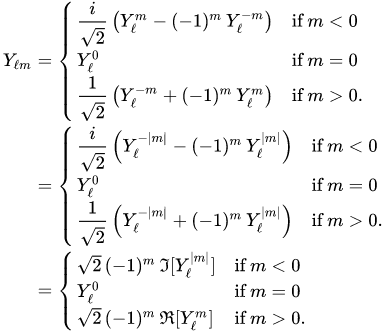

In [ ]:
import math
import torch
import numpy as np
from scipy.special import sph_harm

def Y_lm(l, m, theta, phi):
    # calculate the value of the spherical harmonic
    if m < 0:
        harmonic1 = sph_harm(m, l,  theta, phi)
        harmonic2 = sph_harm(-m, l,  theta, phi)
        result = 1j / np.sqrt(2) * ( harmonic1 - (-1)**m *harmonic2)

    elif m == 0:
        result = sph_harm(0, l,  theta, phi)

    else:
        harmonic1 = sph_harm(-m, l,  theta, phi)
        harmonic2 = sph_harm(m, l,  theta, phi)
        result = 1.0 / np.sqrt(2) * ( harmonic1 + (-1)**m *harmonic2)

    return result

def reduce_dimensions_with_spherical_harmonics(coordinates, l_max):
    num_coordinates = coordinates.shape[0] * coordinates.shape[1]

    r = np.linalg.norm(coordinates, axis=2).reshape((num_coordinates,))
    theta = np.arccos(coordinates[:,:,2].reshape((num_coordinates,)) / r)
    phi = np.arctan2(coordinates[:,:,1].reshape((num_coordinates,)), coordinates[:,:,0].reshape((num_coordinates,)))
    print('r ',r.T)
    print('theta ',theta.T) 
    print('phi',phi.T) 

    invariant=np.zeros((len(theta), l_max+1),dtype=complex)
    expand_matrix = np.zeros((len(theta), (l_max+1)**2),dtype=complex)
    
    print('\n','#'*20,' Start Real Spherical Harmonics Expansion ! ','#'*20,'\n')
 
    for l in range(l_max+1):
      for m in range(-l, l+1):
        
        coef=Y_lm(l, m, theta.T, phi.T)
        print('\n\n','-'*15,'Real Spherical Harmonics Expansion at (l,m) =',(l,m),'-'*15)
        print('Expanded real spherical harmonics basis --> Y_lm : \n',coef)

        invariant[:,l] += coef*coef.conj()/r
        expand_matrix[:,l**2+l+m] = coef
    
    invariant=invariant.reshape((coordinates.shape[0],coordinates.shape[1],(l_max+1)))
    expand_matrix = expand_matrix.reshape((coordinates.shape[0],coordinates.shape[1],(l_max+1)**2))
    
    print('\n\n\n','#'*20,' Real Spherical Harmonics Expansion all done ! ','#'*20,'\n')
    return expand_matrix, invariant


In [ ]:
l_max=3
n=np.array([[[1, 2, 3],
             [15, 11, 7],
             [7, 8, 9]]])
print('Input matrix \n',n.shape)

expand_matrix,invariant=reduce_dimensions_with_spherical_harmonics(n,l_max)

print('\nOutput expand_matrix: \n',expand_matrix)
print('Output invariant: \n',invariant)

Input matrix 
 (1, 3, 3)
r  [ 3.74165739 19.87460691 13.92838828]
theta  [0.64052231 1.21086686 0.86825104]
phi [1.10714872 0.63274884 0.85196633]

 ####################  Start Real Spherical Harmonics Expansion !  #################### 



 --------------- Real Spherical Harmonics Expansion at (l,m) = (0, 0) ---------------
Expanded real spherical harmonics basis --> Y_lm : 
 [0.28209479+0.j 0.28209479+0.j 0.28209479+0.j]


 --------------- Real Spherical Harmonics Expansion at (l,m) = (1, -1) ---------------
Expanded real spherical harmonics basis --> Y_lm : 
 [0.26116903+0.j 0.27042686+0.j 0.28063693+0.j]


 --------------- Real Spherical Harmonics Expansion at (l,m) = (1, 0) ---------------
Expanded real spherical harmonics basis --> Y_lm : 
 [0.21850969+0.j 0.39401151+0.j 0.32174701+0.j]


 --------------- Real Spherical Harmonics Expansion at (l,m) = (1, 1) ---------------
Expanded real spherical harmonics basis --> Y_lm : 
 [0.35039502+0.j 0.10176767+0.j 0.23760091+0.j]


 ------

In [ ]:
#@title #Test Rotation Invariance in 2D
import math
import numpy as np
from scipy.special import sph_harm

def Y_lm(l, m, theta, phi):
    # calculate the value of the spherical harmonic
    if m < 0:
        harmonic1 = sph_harm(m, l,  theta, phi)
        harmonic2 = sph_harm(-m, l,  theta, phi)
        result = 1j / np.sqrt(2) * ( harmonic1 - (-1)**m *harmonic2)

    elif m == 0:
        result = sph_harm(0, l,  theta, phi)

    else:
        harmonic1 = sph_harm(-m, l,  theta, phi)
        harmonic2 = sph_harm(m, l,  theta, phi)
        result = 1.0 / np.sqrt(2) * ( harmonic1 + (-1)**m *harmonic2)

    return result

def xy_real_spherical_harmonics(coordinates, l_max):
    num_coordinates = coordinates.shape[0]
    x, y = coordinates[:,0], coordinates[:,1]

    # Convert to spherical coordinates
    r = np.sqrt(x**2 + y**2)
    theta = np.arccos(y/r)
    phi = np.arctan2(y, x)

    invariant=np.zeros((num_coordinates, l_max+1),dtype=complex)
    expand_matrix = np.zeros((num_coordinates, (l_max+1)**2),dtype=complex)
    
    for l in range(l_max+1):
      for m in range(-l, l+1):
        
        coef=Y_lm(l, m, theta, phi)
        invariant[:,l] += (coef*coef.conj())/r
        expand_matrix[:,l**2+l+m] = coef

    return expand_matrix.real, invariant.real

coordinates=np.array([[1, 1]])
l_max=3

expand_matrix , invariant=xy_real_spherical_harmonics(coordinates, l_max)
print('Invariant output :\n',invariant)

Invariant output :
 [[0.05626977 0.16880931 0.28134885 0.39388839]]


In [ ]:
coordinates=np.array([[1, 1]])
print('Original coordinates:\n', coordinates)

theta=70
theta_rad = np.radians(theta)
R = np.array([[np.cos(theta_rad), -np.sin(theta_rad)], [np.sin(theta_rad), np.cos(theta_rad)]])

coordinates = np.dot(coordinates, R)
print('\n','-'*20,f" Rotating Coordinates by {theta} Degrees ",'-'*20)
print('Rotated coordinates:\n', coordinates)

expand_matrix , invariant=xy_real_spherical_harmonics(coordinates, l_max)
print('\n\nInvariant output from rotated coordinates:\n',invariant)

Original coordinates:
 [[1 1]]

 --------------------  Rotating Coordinates by 70 Degrees  --------------------
Rotated coordinates:
 [[ 1.28171276 -0.59767248]]


Invariant output from rotated coordinates:
 [[0.05626977 0.16880931 0.28134885 0.39388839]]


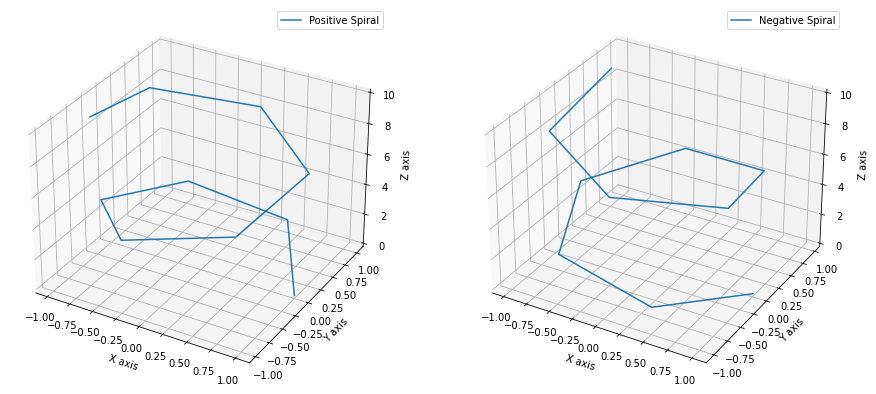

In [ ]:
#@title #Encode Chiral Centre?
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Generate the points along a logarithmic spiral
num_points = 10
t = np.linspace(0, 10, num_points)
x = np.cos(t)
y = np.sin(t)
z = t

# Plot the spirals in opposite directions
fig = plt.figure(figsize=(15,20))
ax = fig.add_subplot(121, projection='3d')
ax.plot(x, y, z, label='Positive Spiral')
ax.legend()

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


ax1 = fig.add_subplot(122, projection='3d')

x_opposite = np.cos(t) 
y_opposite = np.sin(-t) 
z_opposite = t

ax1.plot(x_opposite, y_opposite, z_opposite, label='Negative Spiral')
ax1.legend()
ax1.set_xlabel('X axis')
ax1.set_ylabel('Y axis')
ax1.set_zlabel('Z axis')

plt.show()

In [ ]:
# stack
coordinates = np.column_stack((x, y, z))
coordinates_opposite= np.column_stack((x_opposite, y_opposite, z_opposite))

# reshape
coordinates=coordinates.reshape(1,coordinates.shape[0],-1)
coordinates_opposite=coordinates.reshape(1,coordinates_opposite.shape[0],-1)

In [ ]:
import math
import torch
import numpy as np
from scipy.special import sph_harm

def Y_lm(l, m, theta, phi):
    # calculate the value of the spherical harmonic
    if m < 0:
        harmonic1 = sph_harm(m, l,  theta, phi)
        harmonic2 = sph_harm(-m, l,  theta, phi)
        result = 1j / np.sqrt(2) * ( harmonic1 - (-1)**m *harmonic2)

    elif m == 0:
        result = sph_harm(0, l,  theta, phi)

    else:
        harmonic1 = sph_harm(-m, l,  theta, phi)
        harmonic2 = sph_harm(m, l,  theta, phi)
        result = 1.0 / np.sqrt(2) * ( harmonic1 + (-1)**m *harmonic2)

    return result

def reduce_dimensions_with_spherical_harmonics(coordinates, l_max):
    num_coordinates = coordinates.shape[0] * coordinates.shape[1]

    r = np.linalg.norm(coordinates, axis=2).reshape((num_coordinates,))
    theta = np.arccos(coordinates[:,:,2].reshape((num_coordinates,)) / r)
    phi = np.arctan2(coordinates[:,:,1].reshape((num_coordinates,)), coordinates[:,:,0].reshape((num_coordinates,)))
    #print('r ',r.T)
    #print('theta ',theta.T) 
    #print('phi',phi.T) 

    invariant=np.zeros((len(theta), l_max+1),dtype=complex)
    expand_matrix = np.zeros((len(theta), (l_max+1)**2),dtype=complex)
    
    #print('\n','#'*20,' Start Real Spherical Harmonics Expansion ! ','#'*20,'\n')
 
    for l in range(l_max+1):
      for m in range(-l, l+1):
        
        coef=Y_lm(l, m, theta.T, phi.T)
        #print('\n\n','-'*15,'Real Spherical Harmonics Expansion at (l,m) =',(l,m),'-'*15)
        #print('Expanded real spherical harmonics basis --> Y_lm : \n',coef)

        invariant[:,l] += coef*coef.conj()/r
        expand_matrix[:,l**2+l+m] = coef
    
    invariant=invariant.reshape((coordinates.shape[0],coordinates.shape[1],(l_max+1)))
    expand_matrix = expand_matrix.reshape((coordinates.shape[0],coordinates.shape[1],(l_max+1)**2))
    
    #print('\n\n\n','#'*20,' Real Spherical Harmonics Expansion all done ! ','#'*20,'\n')
    return expand_matrix, invariant


In [ ]:
l_max=3
expand_matrix , invariant=reduce_dimensions_with_spherical_harmonics(coordinates, l_max)
print('Output invariant: \n',invariant)

Output invariant: 
 [[[0.07957747+0.j 0.23873241+0.j 0.39788736+0.j 0.5570423 +0.j]
  [0.05323452+0.j 0.15970357+0.j 0.26617261+0.j 0.37264165+0.j]
  [0.03265578+0.j 0.09796735+0.j 0.16327892+0.j 0.22859048+0.j]
  [0.02286642+0.j 0.06859925+0.j 0.11433209+0.j 0.16006493+0.j]
  [0.01746823+0.j 0.05240468+0.j 0.08734113+0.j 0.12227758+0.j]
  [0.01409739+0.j 0.04229216+0.j 0.07048694+0.j 0.09868171+0.j]
  [0.01180456+0.j 0.03541367+0.j 0.05902279+0.j 0.08263191+0.j]
  [0.01014786+0.j 0.03044357+0.j 0.05073929+0.j 0.071035  +0.j]
  [0.00889635+0.j 0.02668904+0.j 0.04448173+0.j 0.06227442+0.j]
  [0.00791825+0.j 0.02375476+0.j 0.03959127+0.j 0.05542778+0.j]]]


In [ ]:
expand_matrix , invariant_opposite=reduce_dimensions_with_spherical_harmonics(coordinates_opposite, l_max)
print('Output invariant_opposite: \n',invariant_opposite)

Output invariant_opposite: 
 [[[0.07957747+0.j 0.23873241+0.j 0.39788736+0.j 0.5570423 +0.j]
  [0.05323452+0.j 0.15970357+0.j 0.26617261+0.j 0.37264165+0.j]
  [0.03265578+0.j 0.09796735+0.j 0.16327892+0.j 0.22859048+0.j]
  [0.02286642+0.j 0.06859925+0.j 0.11433209+0.j 0.16006493+0.j]
  [0.01746823+0.j 0.05240468+0.j 0.08734113+0.j 0.12227758+0.j]
  [0.01409739+0.j 0.04229216+0.j 0.07048694+0.j 0.09868171+0.j]
  [0.01180456+0.j 0.03541367+0.j 0.05902279+0.j 0.08263191+0.j]
  [0.01014786+0.j 0.03044357+0.j 0.05073929+0.j 0.071035  +0.j]
  [0.00889635+0.j 0.02668904+0.j 0.04448173+0.j 0.06227442+0.j]
  [0.00791825+0.j 0.02375476+0.j 0.03959127+0.j 0.05542778+0.j]]]


In [ ]:
invariant == invariant_opposite

array([[[ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True],
        [ True,  True,  True,  True]]])

Conclusion: Real Spherical Harmonics Expansion can not differentiate chiral centre